In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/exRNA


In [3]:
import os
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
from functools import reduce

In [13]:
input_dir = 'output/feature_selection/evaluate/GSE71008'
records = []
pbar = tqdm_notebook(unit='directory')
for compare_group in os.listdir(input_dir):
    for path in os.listdir(os.path.join(input_dir, compare_group)):
        classifier, n_features, selector, resample_method  = path.split('.')
        record = {
            'compare_group': compare_group,
            'classifier': classifier,
            'n_features': n_features,
            'selector': selector,
            'resample_method': resample_method
        }
        metrics = pd.read_table(os.path.join(input_dir, compare_group, path, 'metrics.{}.txt'.format(resample_method)))
        record['test_roc_auc_mean'] = metrics['test_roc_auc'].mean()
        if resample_method == 'leave_one_out':
            record['test_roc_auc_std'] = 0
        elif resample_method == 'stratified_shuffle_split':
            record['test_roc_auc_std'] = metrics['test_roc_auc'].std()
        pbar.update(1)
        records.append(record)
pbar.close()
records = pd.DataFrame.from_records(records)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

## Feature selection with different combinations of parameters

In [107]:
input_dir = 'output/feature_selection/evaluate/exoRBase'
def plot_performance(input_dir):
    records = []
    pbar = tqdm_notebook(unit='directory')
    for compare_group in os.listdir(input_dir):
        for path in os.listdir(os.path.join(input_dir, compare_group)):
            classifier, n_features, selector, resample_method  = path.split('.')
            record = {
                'compare_group': compare_group,
                'classifier': classifier,
                'n_features': n_features,
                'selector': selector,
                'resample_method': resample_method
            }
            metrics = pd.read_table(os.path.join(input_dir, compare_group, path, 'metrics.{}.txt'.format(resample_method)))
            record['test_roc_auc_mean'] = metrics['test_roc_auc'].mean()
            if resample_method == 'leave_one_out':
                record['test_roc_auc_std'] = 0
            elif resample_method == 'stratified_shuffle_split':
                record['test_roc_auc_std'] = metrics['test_roc_auc'].std()
            pbar.update(1)
            records.append(record)
    pbar.close()
    records = pd.DataFrame.from_records(records)
    records.loc[:, 'n_features'] = records.loc[:, 'n_features'].astype('int')
    compare_groups = records.loc[:, 'compare_group'].unique()

    figsize = 3.5
    # Compare resample methods
    fig, axes = plt.subplots(1, len(compare_groups), 
                             figsize=(figsize*len(compare_groups), figsize),
                             sharey=True, sharex=False)
    for i, compare_group in enumerate(compare_groups):
        if len(compare_groups) > 1:
            ax = axes[i]
        else:
            ax = axes
        sub_df = records.query('compare_group == "{}"'.format(compare_group))
        pivot = sub_df.pivot_table(index=['classifier', 'n_features', 'selector'], 
                  columns=['resample_method'], 
                  values='test_roc_auc_mean')
        ax.scatter(pivot.loc[:, 'leave_one_out'], pivot.loc[:, 'stratified_shuffle_split'], s=12)
        ax.set_xlabel('AUROC (leave_one_out)')
        ax.set_ylabel('AUROC (stratified_shuffle_split)')
        ax.set_xlim(0.5, 1)
        ax.set_ylim(0.5, 1)
        ax.plot([0.5, 1], [0.5, 1], linestyle='dashed', color='gray', linewidth=0.8)
        ax.set_title(compare_group)

    # Compare classifiers
    fig, axes = plt.subplots(1, len(compare_groups), 
                             figsize=(figsize*len(compare_groups), figsize),
                             sharey=True, sharex=False)
    for i, compare_group in enumerate(compare_groups):
        if len(compare_groups) > 1:
            ax = axes[i]
        else:
            ax = axes
        sub_df = records.query('compare_group == "{}"'.format(compare_group))
        pivot = sub_df.pivot_table(index=['resample_method', 'n_features', 'selector'], 
                  columns=['classifier'], 
                  values='test_roc_auc_mean')
        ax.scatter(pivot.loc[:, 'logistic_regression'], pivot.loc[:, 'random_forest'], s=12)
        ax.set_xlabel('AUROC (logistic_regression)')
        ax.set_ylabel('AUROC (random_forest)')
        ax.set_xlim(0.5, 1)
        ax.set_ylim(0.5, 1)
        ax.plot([0.5, 1], [0.5, 1], linestyle='dashed', color='gray', linewidth=0.8)
        ax.set_title(compare_group)

    # Compare number of features
    fig, axes = plt.subplots(1, len(compare_groups), 
                             figsize=(figsize*len(compare_groups), figsize),
                             sharey=False, sharex=False)
    for i, compare_group in enumerate(compare_groups):
        if len(compare_groups) > 1:
            ax = axes[i]
        else:
            ax = axes
        sub_df = records.query('compare_group == "{}"'.format(compare_group))
        pivot3 = sub_df.pivot_table(index=['classifier', 'selector', 'resample_method'], 
                  columns=['n_features'], 
                  values='test_roc_auc_mean')
        ax.plot(np.repeat(pivot3.columns.values.reshape((-1, 1)), pivot3.shape[0], axis=1),
                pivot3.values.T)
        ax.set_ylim(0.5, 1)
        ax.set_xlabel('Number of features')
        ax.set_ylabel('AUROC')
        ax.set_title(compare_group)

    # Compare feature selection methods
    fig, axes = plt.subplots(1, len(compare_groups), 
                             figsize=(figsize*len(compare_groups), figsize),
                             sharey=True, sharex=False)
    for i, compare_group in enumerate(compare_groups):
        if len(compare_groups) > 1:
            ax = axes[i]
        else:
            ax = axes
        sub_df = records.query('compare_group == "{}"'.format(compare_group))
        pivot = sub_df.pivot_table(index=['classifier', 'n_features', 'resample_method'], 
                  columns=['selector'], 
                  values='test_roc_auc_mean')
        ax.plot(np.repeat(pivot4.columns.values.reshape((-1, 1)), pivot4.shape[0], axis=1),
                pivot4.values.T)
        ax.set_ylim(0.5, 1)
        ax.set_xlabel('Feature selection method')
        ax.set_ylabel('AUROC')
        ax.set_title(compare_group)
    return records

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

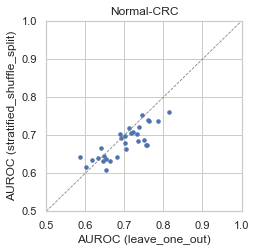

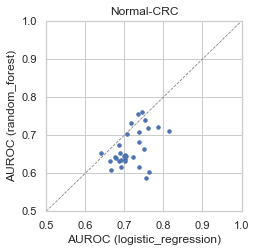

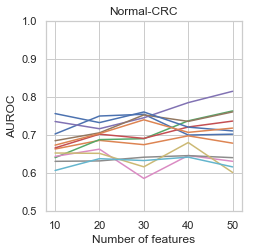

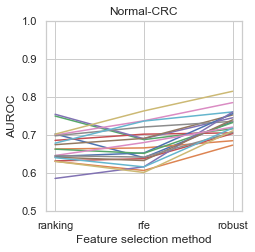

In [108]:
summary = {}
summary['GSE71008'] = plot_performance('output/feature_selection/evaluate/GSE71008')

In [132]:
summary['GSE71008'].query(
    'resample_method == "stratified_shuffle_split"').sort_values(
    'test_roc_auc_mean', ascending=False).groupby(
    ['compare_group', 'resample_method']).head(1)

classifier compare_group  n_features           resample_method  \
30  logistic_regression    Normal-CRC          50  stratified_shuffle_split   

   selector  test_roc_auc_mean  test_roc_auc_std  
30   robust             0.7612          0.095717

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

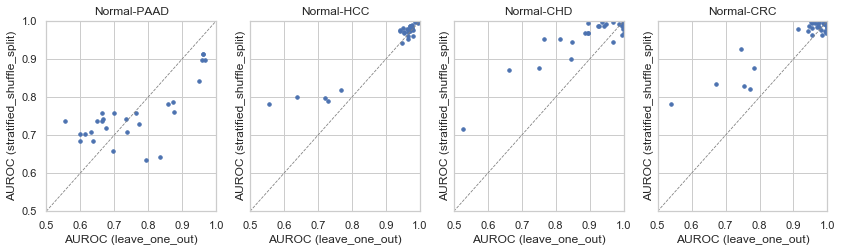

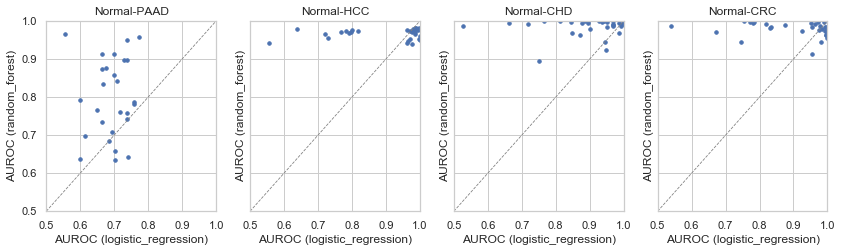

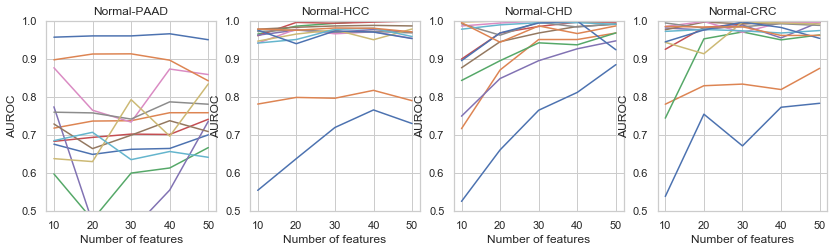

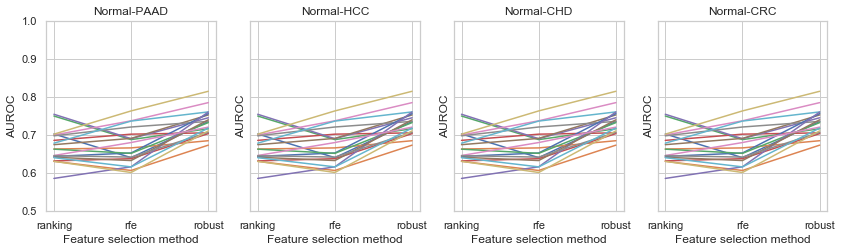

In [113]:
summary['exoRBase'] = plot_performance('output/feature_selection/evaluate/exoRBase')

In [131]:
summary['exoRBase'].query(
    'resample_method == "stratified_shuffle_split"').sort_values(
    'test_roc_auc_mean', ascending=False).groupby(
    ['compare_group', 'resample_method']).head(1)

classifier compare_group  n_features           resample_method  \
106  logistic_regression    Normal-HCC          50  stratified_shuffle_split   
239  logistic_regression    Normal-CRC          40  stratified_shuffle_split   
166  logistic_regression    Normal-CHD          50  stratified_shuffle_split   
54         random_forest   Normal-PAAD          30  stratified_shuffle_split   

    selector  test_roc_auc_mean  test_roc_auc_std  
106      rfe           1.000000          0.000000  
239      rfe           0.998571          0.010102  
166      rfe           0.997143          0.020203  
54    robust           0.913810          0.131196

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

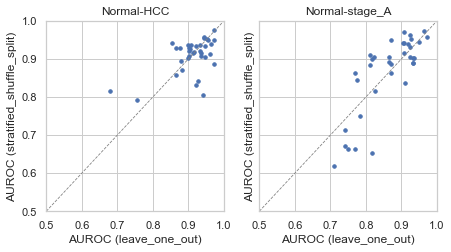

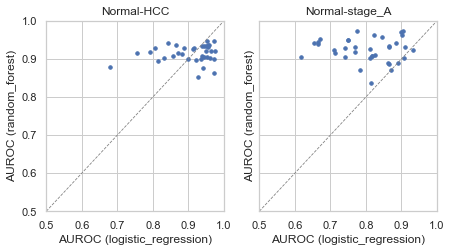

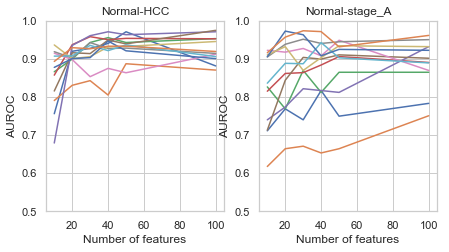

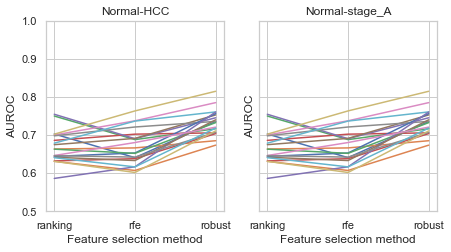

In [123]:
summary['piranha_peaks'] = plot_performance('output/feature_selection/evaluate/piranha_peaks')

In [130]:
summary['piranha_peaks'].query(
    'resample_method == "stratified_shuffle_split"').sort_values(
    'test_roc_auc_mean', ascending=False).groupby(
    ['compare_group', 'resample_method']).head(1)

classifier   compare_group  n_features  \
63   logistic_regression      Normal-HCC         100   
136        random_forest  Normal-stage_A          30   

              resample_method selector  test_roc_auc_mean  test_roc_auc_std  
63   stratified_shuffle_split   robust           0.975556          0.051630  
136  stratified_shuffle_split   robust           0.974444          0.068466

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

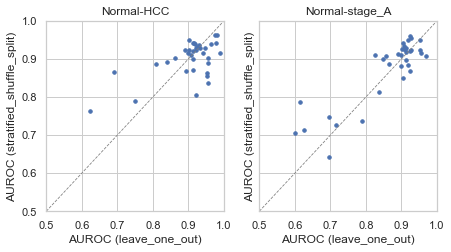

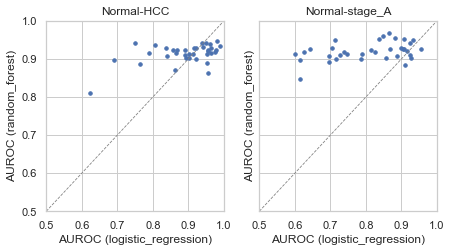

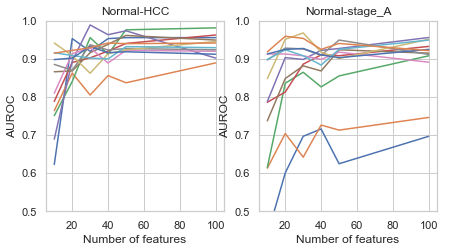

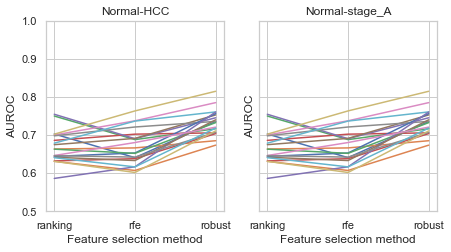

In [122]:
summary['piranha_peaks_iterative'] = plot_performance('output/feature_selection/evaluate/piranha_peaks_iterative/')

In [129]:
summary['piranha_peaks_iterative'].query(
    'resample_method == "stratified_shuffle_split"').sort_values(
    'test_roc_auc_mean', ascending=False).groupby(
    ['compare_group', 'resample_method']).head(1)

classifier   compare_group  n_features  \
41   logistic_regression      Normal-HCC         100   
101        random_forest  Normal-stage_A          20   

              resample_method selector  test_roc_auc_mean  test_roc_auc_std  
41   stratified_shuffle_split      rfe           0.963333          0.077445  
101  stratified_shuffle_split   robust           0.960000          0.079397

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

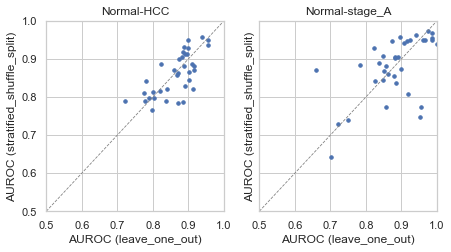

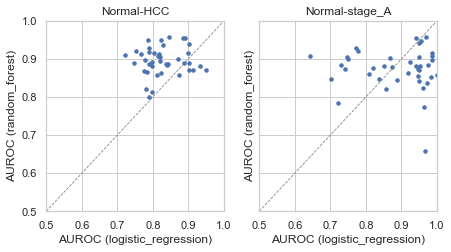

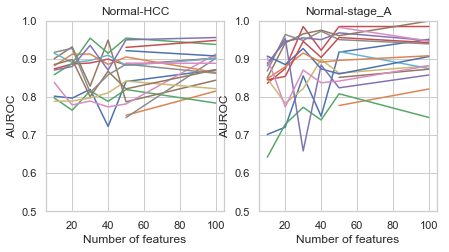

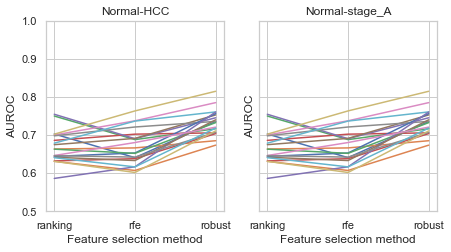

In [126]:
summary['transcripts_exrna'] = plot_performance('output/feature_selection/evaluate/transcripts_exrna/')

In [128]:
summary['transcripts_exrna'].query(
    'resample_method == "stratified_shuffle_split"').sort_values(
    'test_roc_auc_mean', ascending=False).groupby(
    ['compare_group', 'resample_method']).head(1)

classifier   compare_group  n_features  \
101  logistic_regression  Normal-stage_A          40   
67         random_forest      Normal-HCC         100   

              resample_method selector  test_roc_auc_mean  test_roc_auc_std  
101  stratified_shuffle_split   robust           0.973333          0.079555  
67   stratified_shuffle_split      rfe           0.956667          0.088406

## Use fewer features (<= 10)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

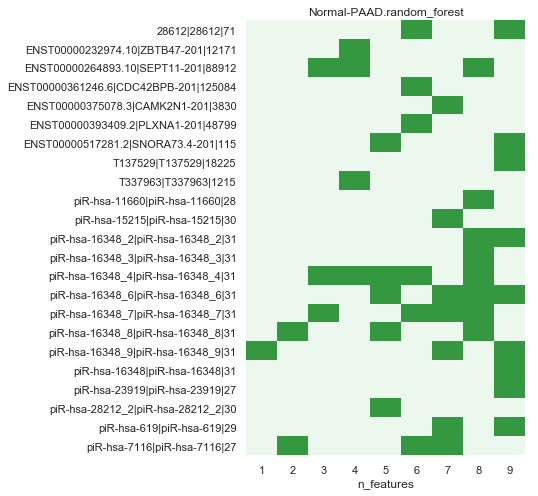

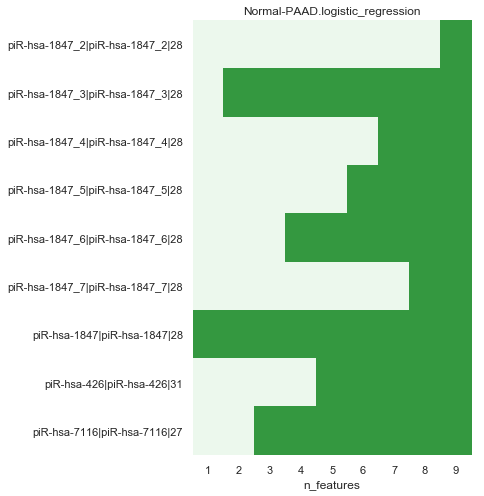

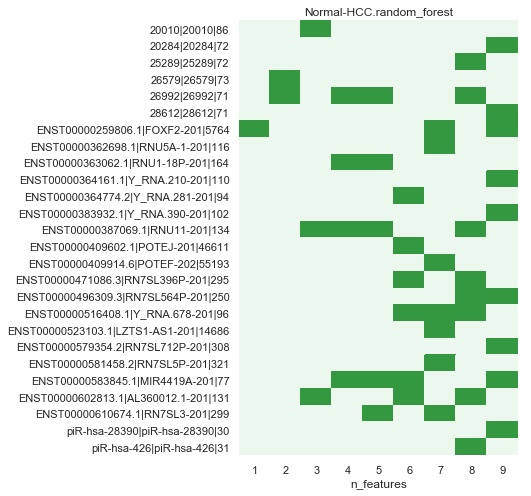

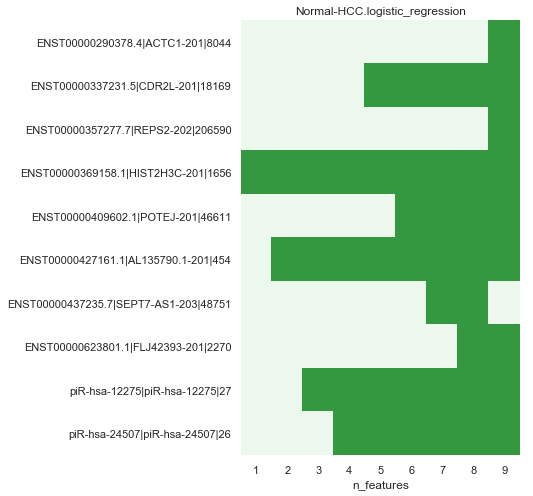

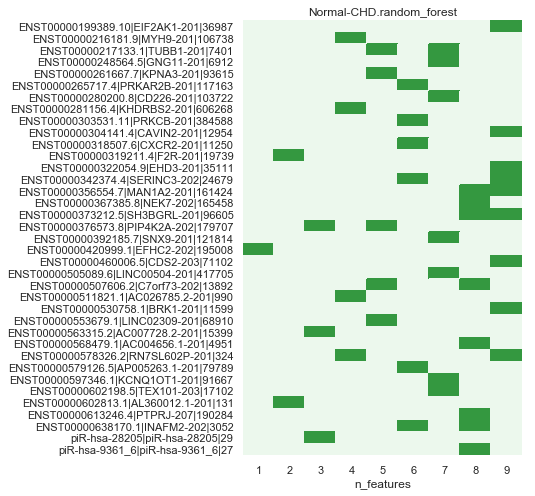

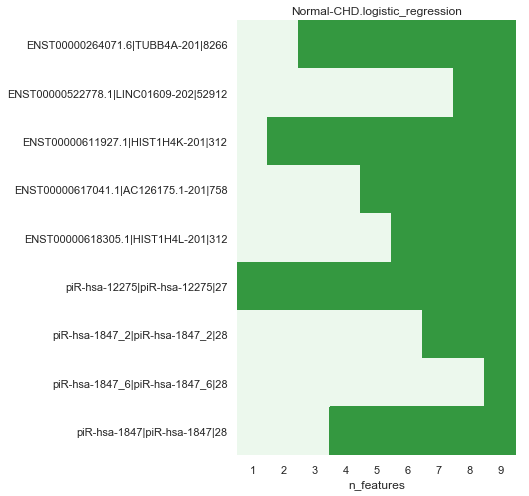

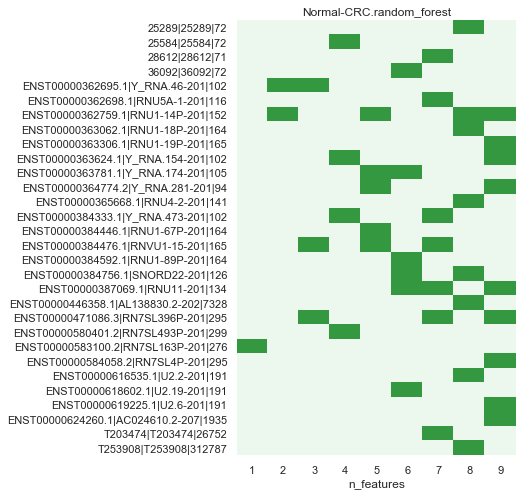

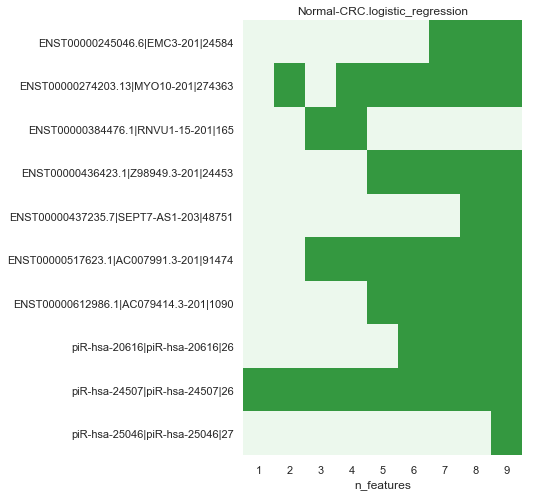

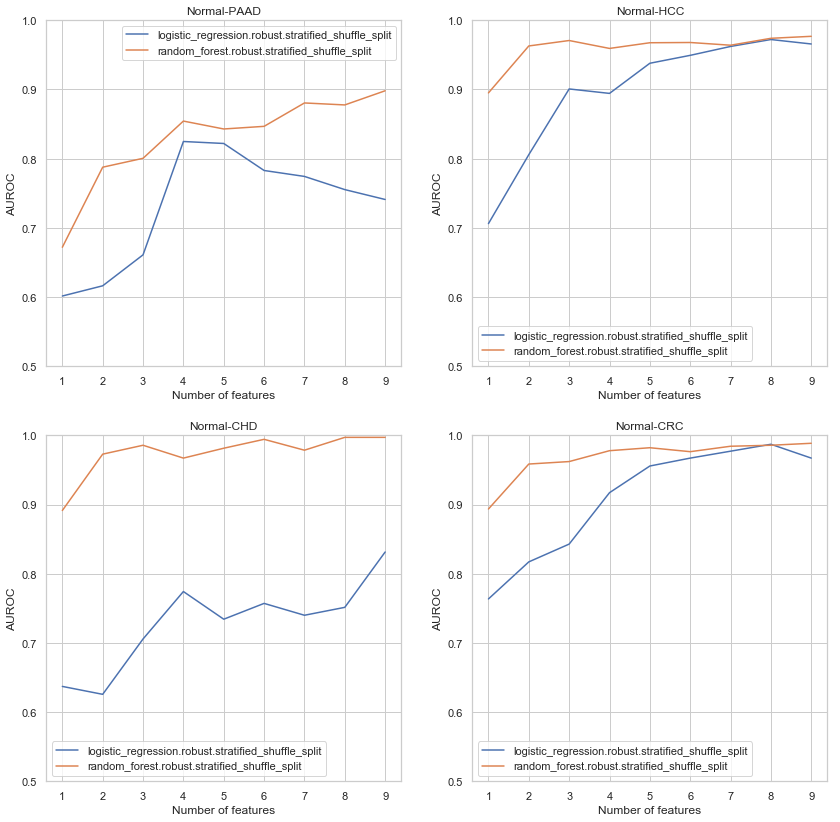

In [215]:
def plot_metrics(input_dir):
    records = []
    features = []
    pbar = tqdm_notebook(unit='directory')
    for compare_group in os.listdir(input_dir):
        for path in os.listdir(os.path.join(input_dir, compare_group)):
            classifier, n_features, selector, resample_method  = path.split('.')
            if int(n_features) >= 10:
                continue
            record = {
                'compare_group': compare_group,
                'classifier': classifier,
                'n_features': n_features,
                'selector': selector,
                'resample_method': resample_method
            }
            metrics = pd.read_table(os.path.join(input_dir, compare_group, path, 'metrics.{}.txt'.format(resample_method)))
            record['test_roc_auc_mean'] = metrics['test_roc_auc'].mean()
            if resample_method == 'leave_one_out':
                record['test_roc_auc_std'] = 0
            elif resample_method == 'stratified_shuffle_split':
                record['test_roc_auc_std'] = metrics['test_roc_auc'].std()
            features_s = pd.read_table(os.path.join(input_dir, compare_group, path, 'features.txt'), 
                                       header=None).iloc[:, 0].values
            features.append((record, features_s))
            pbar.update(1)
            records.append(record)
    pbar.close()
    
    records = pd.DataFrame.from_records(records)
    records.loc[:, 'n_features'] = records.loc[:, 'n_features'].astype('int')
    compare_groups = records.loc[:, 'compare_group'].unique()
    figsize = 7
    
    feature_union = reduce(np.union1d, [a[1] for a in features])
    feature_keys = ['compare_group', 'classifier', 'n_features', 'selector', 'resample_method']
    feature_meta = []
    columns = [[] for i in range(len(feature_keys))]
    for params, feature_s in features:
        feature_meta_s = {}
        for i, key in enumerate(feature_keys):
            columns[i].append(params[key])
            feature_meta_s[key] = params[key]
        feature_meta.append(feature_meta_s)
    feature_meta = pd.DataFrame.from_records(feature_meta)
    feature_meta['n_features'] = feature_meta['n_features'].astype(np.int32)
    feature_meta = feature_meta.sort_values('n_features')
    
    feature_matrix = pd.DataFrame(np.zeros((feature_union.shape[0], len(features)), dtype=np.int32),
                                  index=feature_union)
    
    for i in range(len(features)):
        feature_matrix.loc[features[i][1], i] = 1
    #feature_matrix.columns = columns
    #feature_matrix.columns.names = column_keys
    feature_matrix.columns = ['.'.join(values) for values in zip(*columns)]
    
    # Plot feature matrix
    classifiers = feature_meta.loc[:, 'classifier'].unique()
    #fig, axes = plt.subplots(len(compare_groups)*len(classifiers),
    #                         figsize=(8, 7*len(compare_groups)*len(classifiers)))
    cmap = sns.light_palette((127/360.0, 40/100.0, 49/100.0), n_colors=2, input='hls', as_cmap=True)
    for i, compare_group in enumerate(compare_groups):
        for j, classifier in enumerate(classifiers):
            indices = feature_meta.query('(compare_group == "{}") and (classifier == "{}")'.format(
                compare_group, classifier)).index.values
            sub_df = feature_matrix.iloc[:, indices]
            sub_df = sub_df.loc[sub_df.sum(axis=1) > 0].copy()
            sub_df.columns = feature_meta.loc[indices, 'n_features']
            fig, ax = plt.subplots(figsize=(5, 8))
            sns.heatmap(sub_df, cmap=cmap, ax=ax, cbar=False)
            ax.set_title('{}.{}'.format(compare_group, classifier))
    
    # Compare number of features
    figsize = 7
    n_cols = min(len(compare_groups), 2)
    n_rows = int(np.ceil(len(compare_groups)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize*n_cols, figsize*n_rows),
                             sharey=False, sharex=False)
    for i, compare_group in enumerate(compare_groups):
        if (n_cols > 1) and (n_rows == 1):
            ax = axes[i]
        elif n_rows > 1:
            ax = axes[i//n_cols, i%n_cols]
        else:
            ax = axes
        sub_df = records.query('compare_group == "{}"'.format(compare_group))
        pivot3 = sub_df.pivot_table(index=['classifier', 'selector', 'resample_method'], 
                  columns=['n_features'], 
                  values='test_roc_auc_mean').dropna()
        #ax.plot(np.repeat(pivot3.columns.values.reshape((-1, 1)), pivot3.shape[0], axis=1),
        #        pivot3.values.T)
        for i_line, label in enumerate(pivot3.index):
            label = '.'.join(label)
            ax.plot(pivot3.columns.values, pivot3.iloc[i_line], label=label)
        ax.set_ylim(0.5, 1)
        ax.set_xlabel('Number of features')
        ax.set_ylabel('AUROC')
        ax.set_title(compare_group)
        ax.legend()
        
    return feature_meta

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

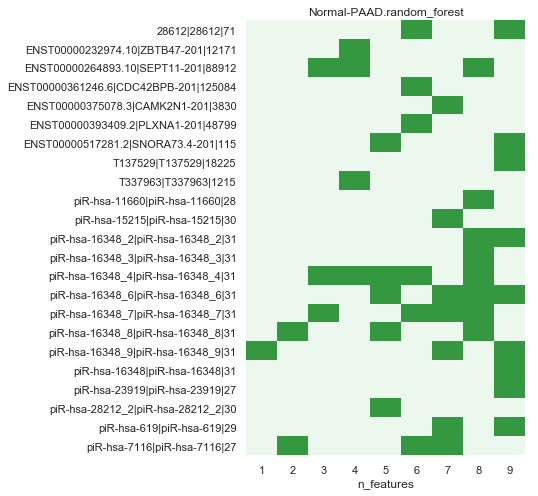

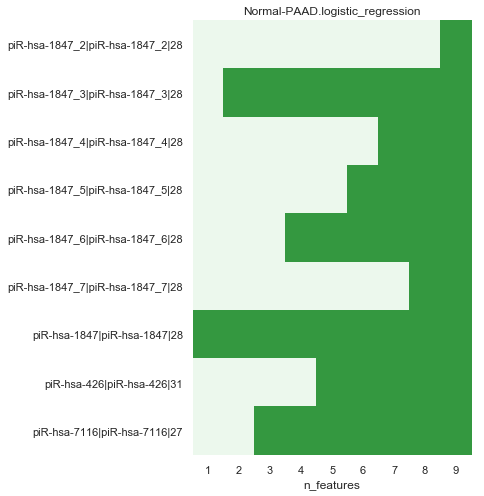

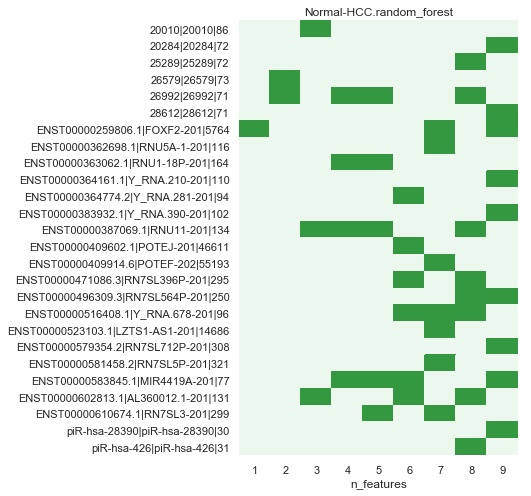

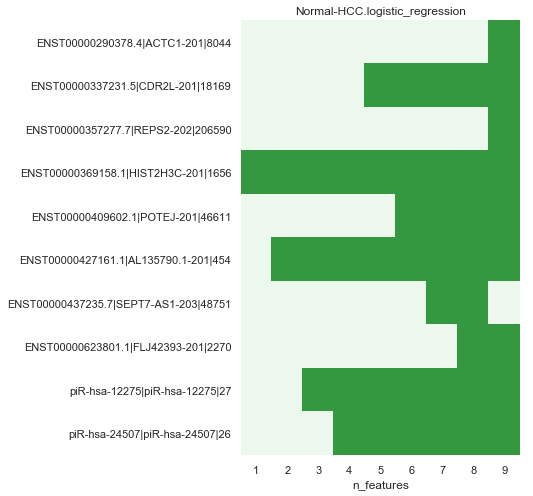

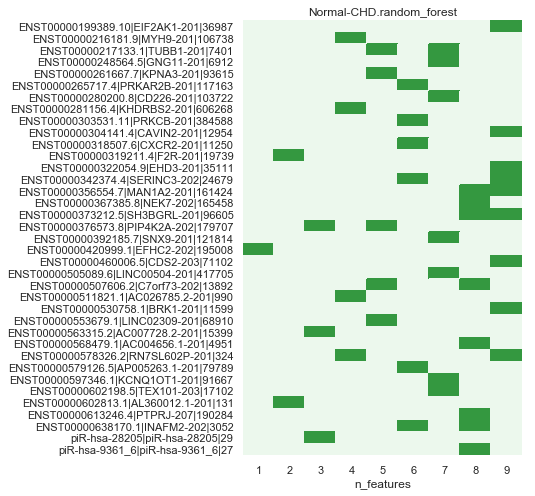

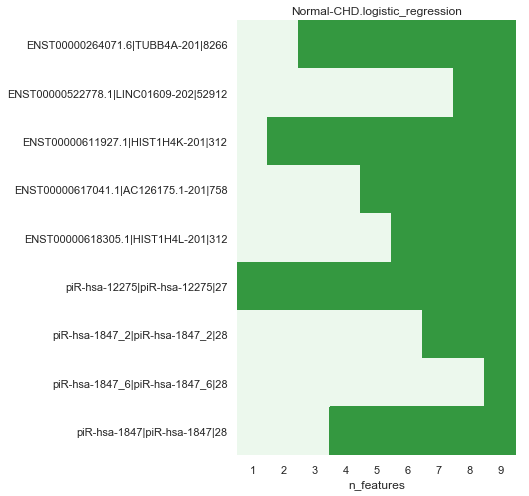

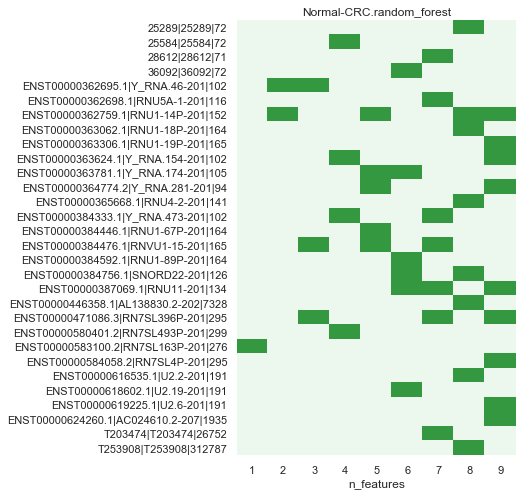

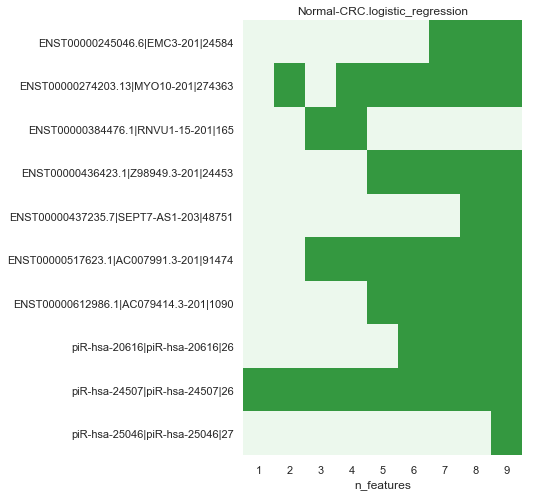

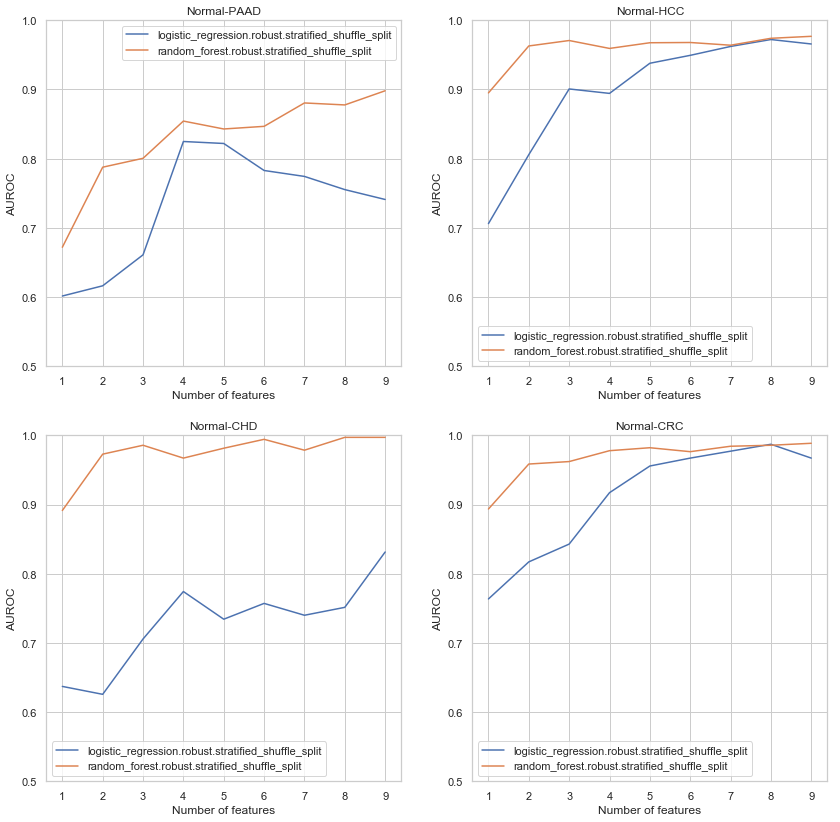

In [220]:
feature_meta = plot_metrics('output/feature_selection/evaluate/exoRBase/')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

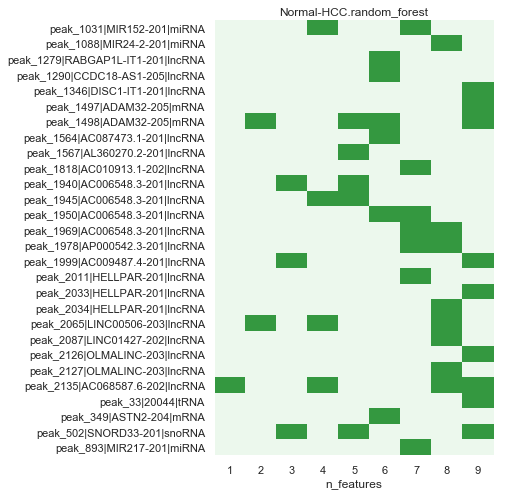

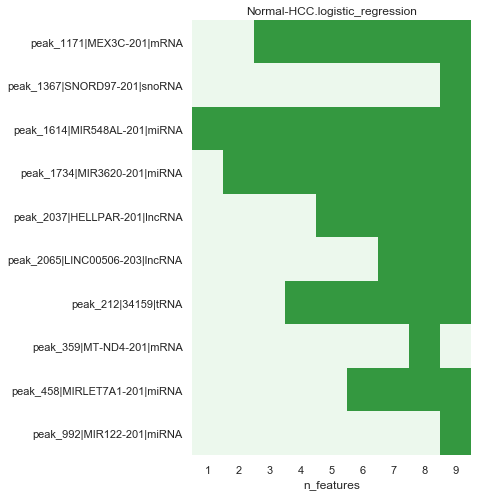

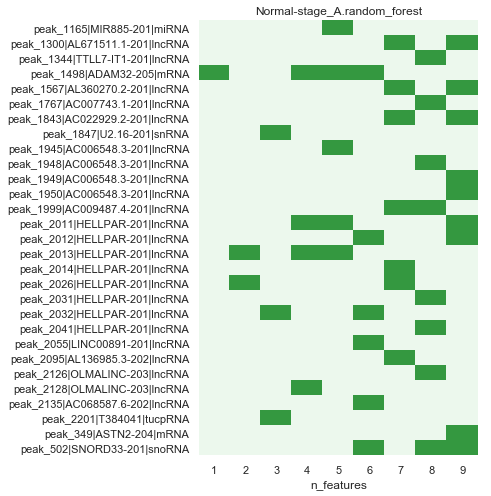

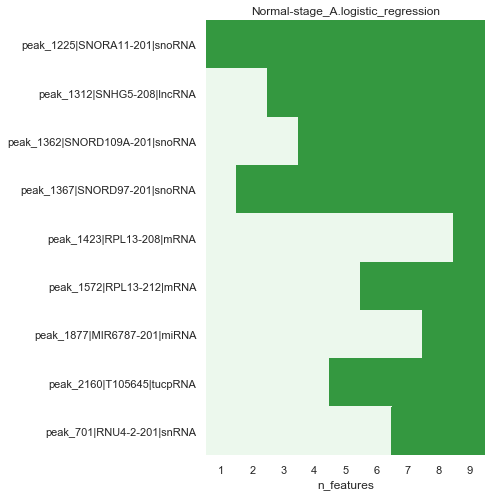

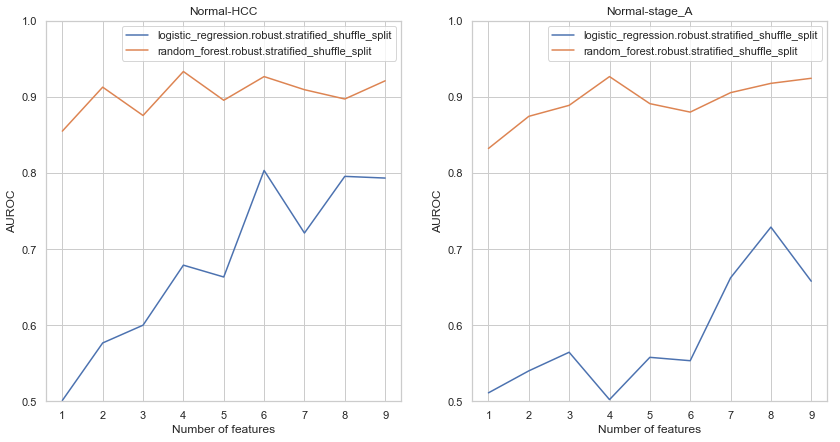

In [216]:
feature_meta = plot_metrics('output/feature_selection/evaluate/hccpeakiter_removed/')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

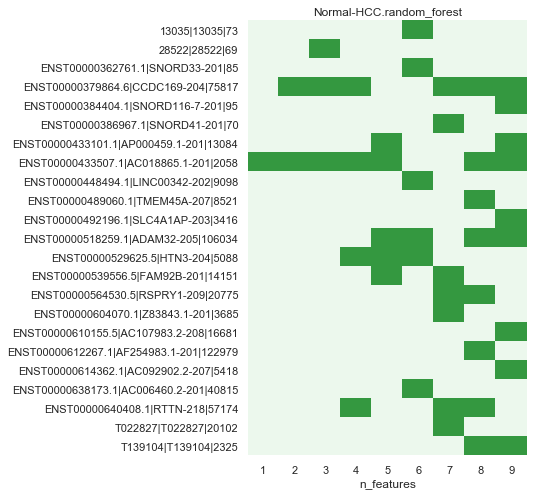

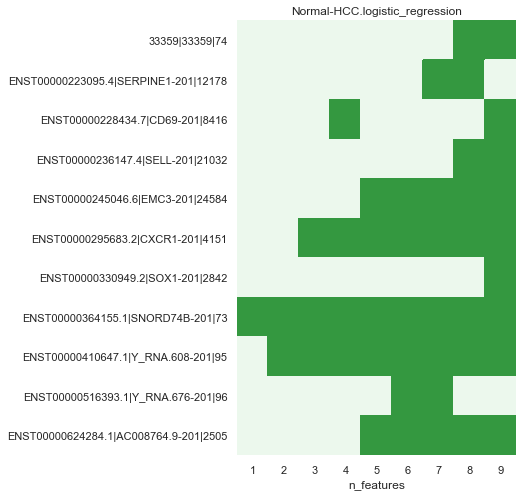

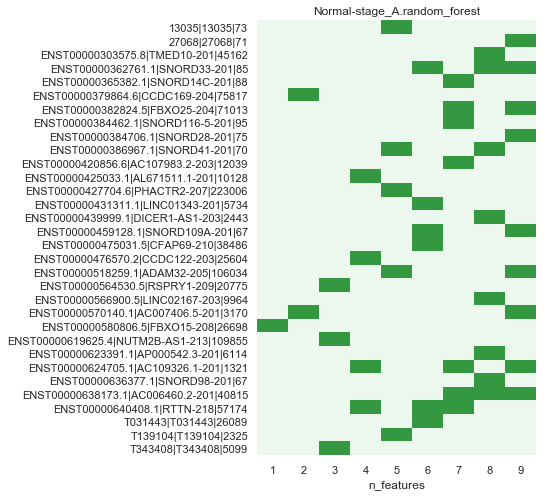

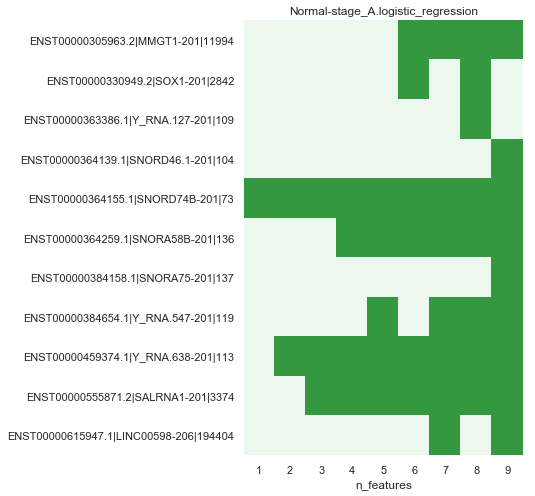

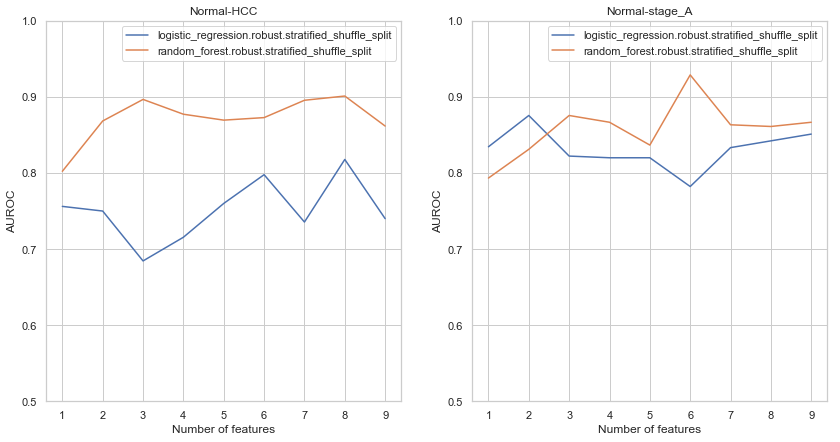

In [217]:
feature_meta = plot_metrics('output/feature_selection/evaluate/hccfull_removed/')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

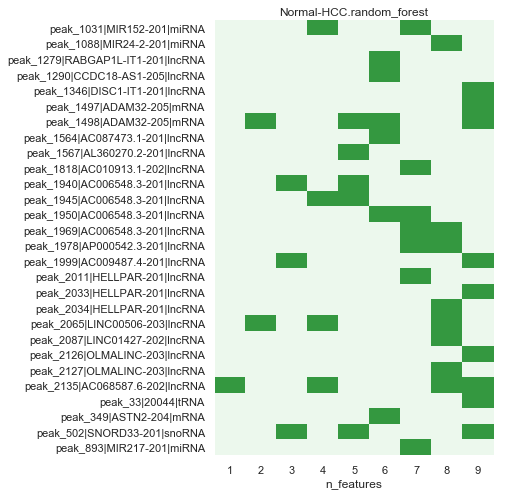

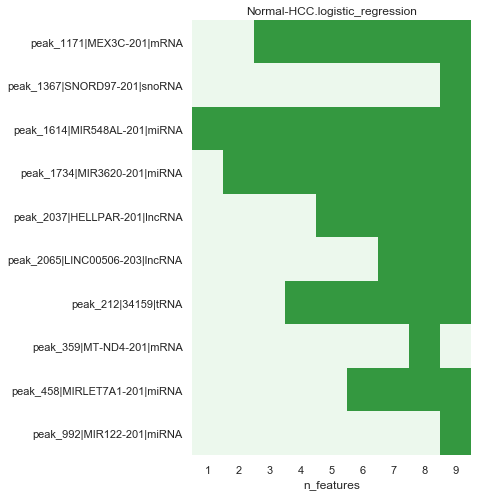

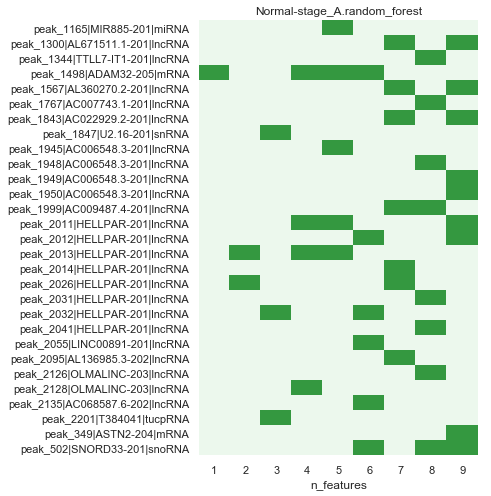

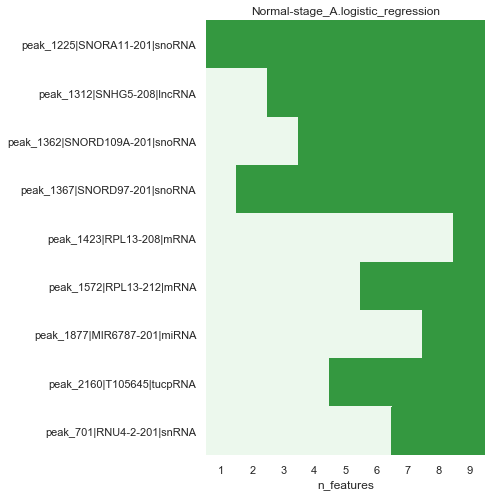

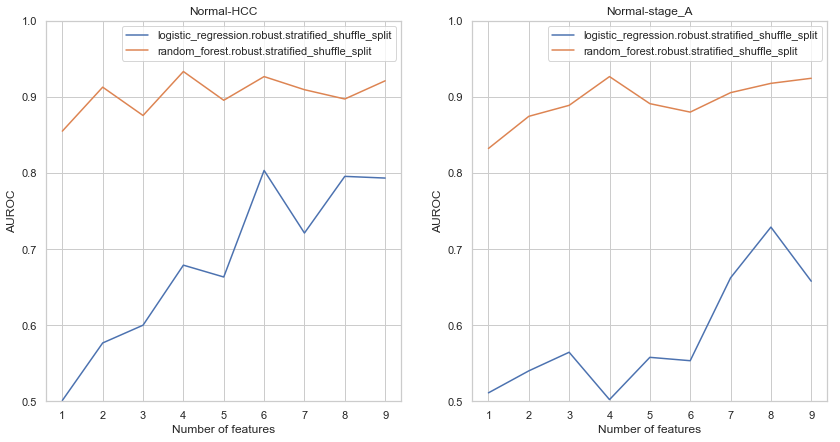

In [218]:
feature_meta = plot_metrics('output/feature_selection/evaluate/hccpeakiter_removed/')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

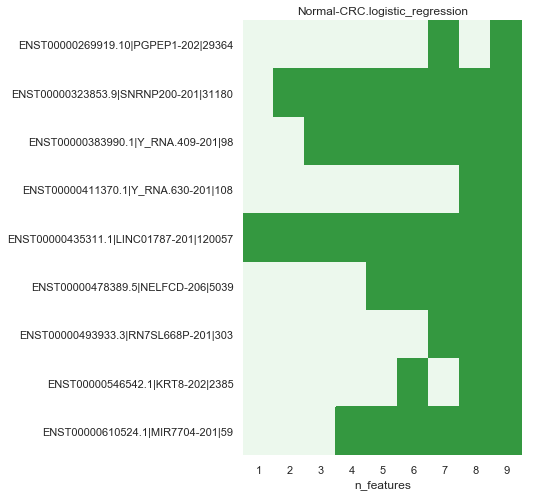

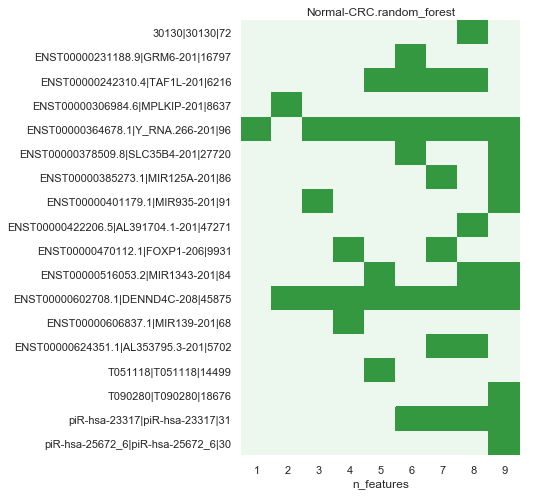

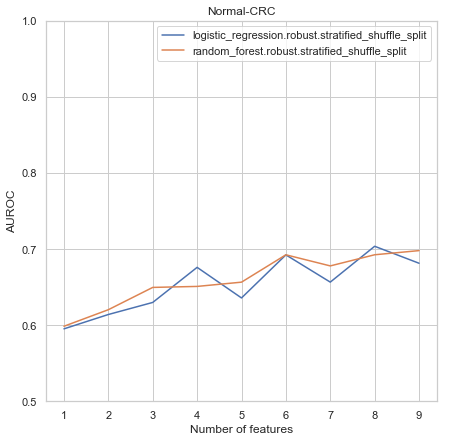

In [219]:
feature_meta = plot_metrics('output/feature_selection/evaluate/GSE71008/')

## Evaluate batch effect

In [182]:
def evaluate_preprocess_methods(input_dirs, preprocess_methods, title=None):
    records = []
    pbar = tqdm_notebook(unit='directory')
    for preprocess_method, input_dir in zip(preprocess_methods, input_dirs):
        for compare_group in os.listdir(input_dir):
            for path in os.listdir(os.path.join(input_dir, compare_group)):
                classifier, n_features, selector, resample_method  = path.split('.')
                if int(n_features) > 11:
                    continue
                if (classifier != 'random_forest') or (selector != 'robust'):
                    continue
                if resample_method != 'stratified_shuffle_split':
                    continue
                record = {
                    'compare_group': compare_group,
                    'classifier': classifier,
                    'n_features': n_features,
                    'selector': selector,
                    'resample_method': resample_method,
                    'preprocess_method': preprocess_method
                }
                metrics = pd.read_table(os.path.join(input_dir, compare_group, path, 'metrics.{}.txt'.format(resample_method)))
                record['test_roc_auc_mean'] = metrics['test_roc_auc'].mean()
                if resample_method == 'leave_one_out':
                    record['test_roc_auc_std'] = 0
                elif resample_method == 'stratified_shuffle_split':
                    record['test_roc_auc_std'] = metrics['test_roc_auc'].std()
                pbar.update(1)
                records.append(record)
    pbar.close()
    records = pd.DataFrame.from_records(records)
    records['n_features'] = records.loc[:, 'n_features'].astype(np.int32)
    for compare_group, sub_df in records.groupby('compare_group'):
        pivot = sub_df.pivot_table(
            index='preprocess_method', columns='n_features', values='test_roc_auc_mean')
        #print(pivot.iloc[:, 0])
        #print(np.argsort(np.argsort(pivot.values, axis=0), axis=0)[:, 0])
        mean_ranks = np.mean(pivot.shape[0] - np.argsort(np.argsort(pivot.values, axis=0), axis=0), axis=1)
        mean_ranks = pd.Series(mean_ranks, index=pivot.index.values)
        mean_ranks = mean_ranks.sort_values()
        rename_index = ['{} (rank = {:.1f})'.format(name, value) for name, value in zip(mean_ranks.index, mean_ranks.values)]
        rename_index = pd.Series(rename_index, index=mean_ranks.index.values)
        sub_df = sub_df.copy()
        sub_df['preprocess_method'] = rename_index[sub_df['preprocess_method'].values].values
        fig, ax = plt.subplots(figsize=(8, 8))                      
        sns.lineplot('n_features', 'test_roc_auc_mean', hue='preprocess_method', data=sub_df, 
                  ci=None, ax=ax, markers='o', hue_order=rename_index.values)
        ax.set_ylim(0.5, 1)
        if title:
            ax.set_title(title + ', ' + compare_group)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

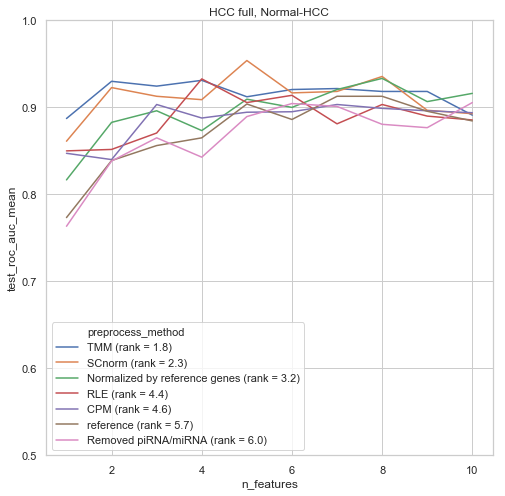

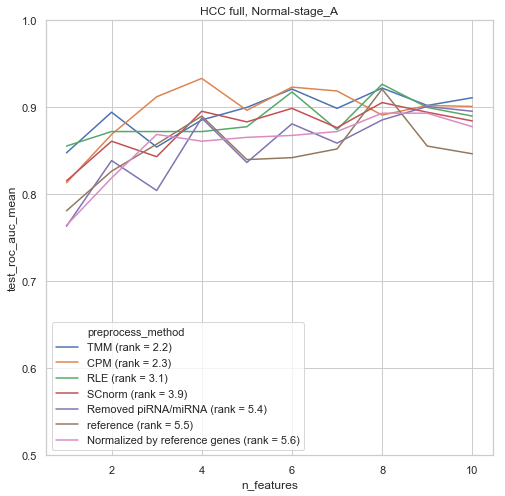

In [183]:
evaluate_preprocess_methods(['output/feature_selection/evaluate/transcripts_exrna',
                             'output/feature_selection/evaluate/hccfull_ref_normalization',
                             'output/feature_selection/evaluate/hccfull_removed',
                             'output/feature_selection/evaluate/rle.transcripts_exrna_43',
                             'output/feature_selection/evaluate/scnorm.transcripts_exrna',
                             'output/feature_selection/evaluate/tmm.transcripts_exrna_43',
                             'output/feature_selection/evaluate/reference.transcripts_exrna_43'
                        ],
                       preprocess_methods=[
                           'CPM', 
                           'Normalized by reference genes', 
                           'Removed piRNA/miRNA',
                           'RLE',
                           'SCnorm',
                           'TMM',
                           'reference'
                       ],
                       title='HCC full')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

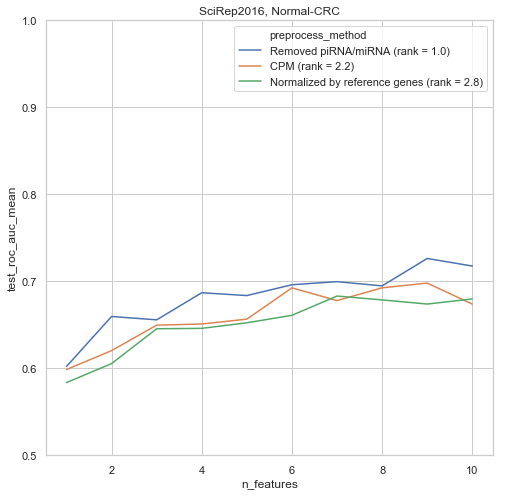

In [197]:
evaluate_preprocess_methods(['output/feature_selection/evaluate/GSE71008',
                       'output/feature_selection/evaluate/scirep_ref_normalization',
                       'output/feature_selection/evaluate/scirep_removed'],
                       preprocess_methods=['CPM', 'Normalized by reference genes', 'Removed piRNA/miRNA'],
                       title='SciRep2016')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

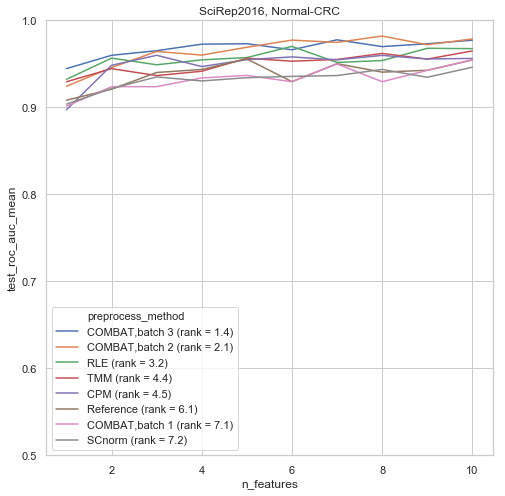

In [190]:
evaluate_preprocess_methods(['output/feature_selection/evaluate/cpm.scirep_sequential_qc',
                             'output/feature_selection/evaluate/rle.scirep_sequential_qc',
                             'output/feature_selection/evaluate/tmm.scirep_sequential_qc',
                             'output/feature_selection/evaluate/scnorm.GSE71008',
                             'output/feature_selection/evaluate/reference.scirep_sequential_qc',
                             'output/feature_selection/evaluate/reversed.logged.combat.batch_1.scirep_sequential_qc_variance',
                             'output/feature_selection/evaluate/reversed.logged.combat.batch_2.scirep_sequential_qc_variance',
                             'output/feature_selection/evaluate/reversed.logged.combat.batch_3.scirep_sequential_qc_variance'],
                       preprocess_methods=[
                           'CPM',
                           'RLE',
                           'TMM',
                           'SCnorm',
                           'Reference',
                           'COMBAT,batch 1',
                           'COMBAT,batch 2',
                           'COMBAT,batch 3'
                       ],
                       title='SciRep2016')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

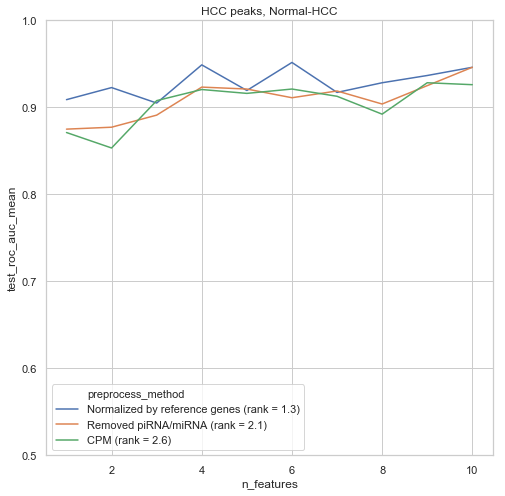

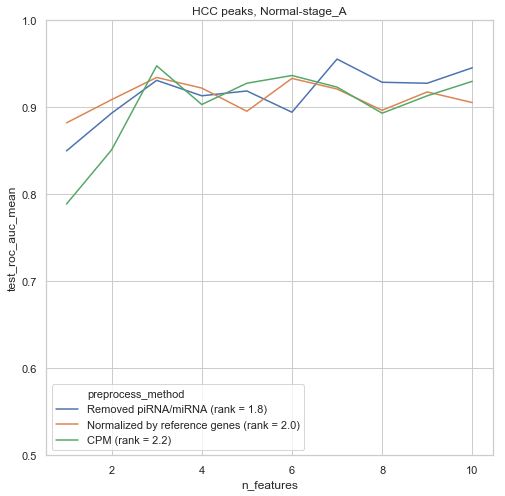

In [186]:
evaluate_preprocess_methods(['output/feature_selection/evaluate/piranha_peaks',
                       'output/feature_selection/evaluate/hccpeak_ref_normalization',
                       'output/feature_selection/evaluate/hccpeak_removed'],
                       preprocess_methods=[
                           'CPM', 
                           'Normalized by reference genes', 
                           'Removed piRNA/miRNA'],
                       title='HCC peaks')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

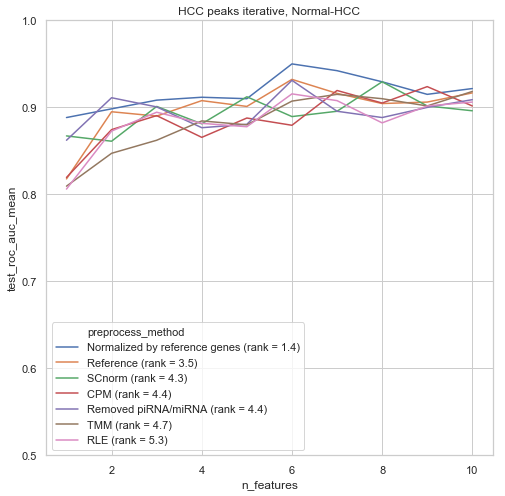

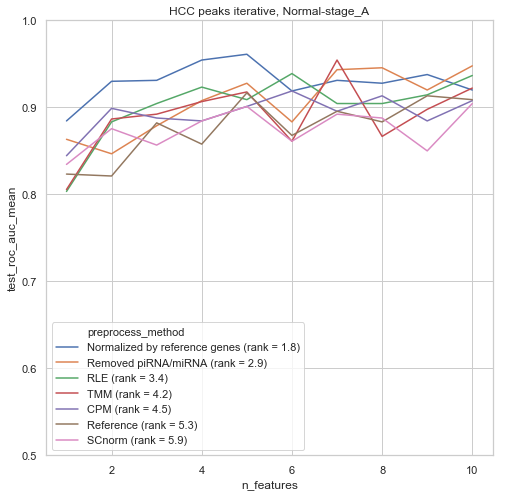

In [187]:
evaluate_preprocess_methods(['output/feature_selection/evaluate/piranha_peaks_iterative',
                       'output/feature_selection/evaluate/hccpeakiter_ref_normalization',
                       'output/feature_selection/evaluate/hccpeakiter_removed',
                       'output/feature_selection/evaluate/rle.piranha_peaks_iterative_43',
                       'output/feature_selection/evaluate/scnorm.piranha_peaks_iterative',
                       'output/feature_selection/evaluate/tmm.piranha_peaks_iterative_43',
                       'output/feature_selection/evaluate/reference.piranha_peaks_iterative_43'],
                       preprocess_methods=[
                           'CPM', 
                           'Normalized by reference genes',
                           'Removed piRNA/miRNA',
                           'RLE',
                           'SCnorm',
                           'TMM',
                           'Reference'
                       ],
                       title='HCC peaks iterative')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

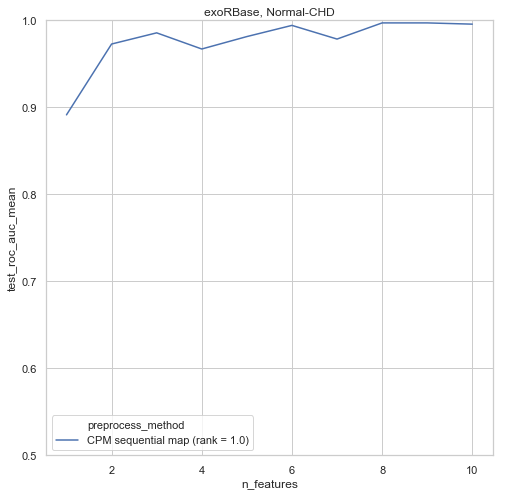

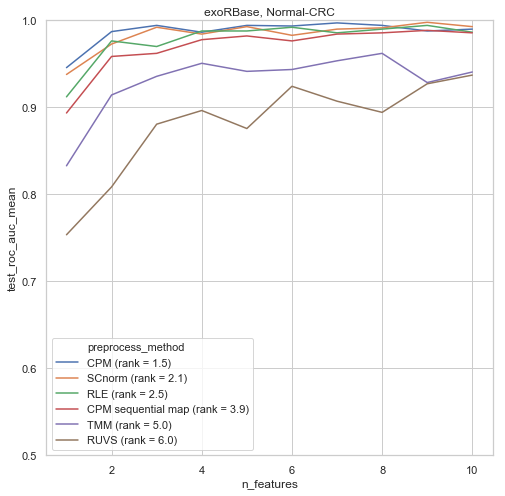

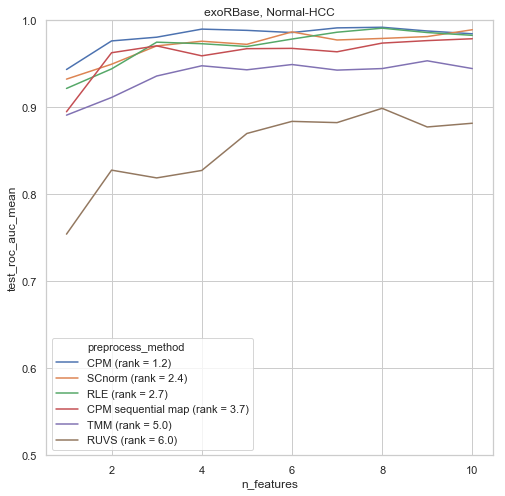

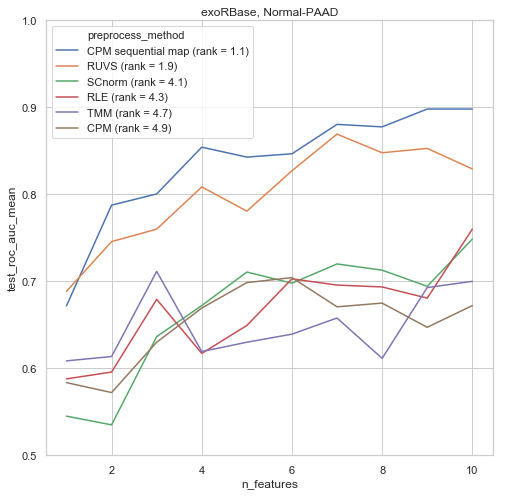

In [191]:
evaluate_preprocess_methods(['output/feature_selection/evaluate/exoRBase',
                            'output/feature_selection/evaluate/exoRBase_remapped',
                            'output/feature_selection/evaluate/rle.exoRBase',
                            'output/feature_selection/evaluate/scnorm.exoRBase',
                            'output/feature_selection/evaluate/tmm.exoRBase',
                            'output/feature_selection/evaluate/reversed.logged.ruvs.exoRBase_variance'],
                       preprocess_methods=[
                           'CPM sequential map',
                           'CPM',
                           'RLE',
                           'TMM',
                           'SCnorm',
                           'RUVS'
                       ],
                       title='exoRBase')

## Compare features

In [58]:
feature_fields = {}
feature_fields['exoRBase'] = ('transcript_id', 'transcript_name', 'gene_length')
feature_fields['exoRBase_remapped'] = ('gene_id',)
feature_fields['rle.exoRBase'] = ('gene_type', 'gene_id')
feature_fields['transcripts_exrna'] = ('transcript_id', 'transcript_name', 'transcript_length')
feature_fields['piranha_peaks'] = ('peak_id', 'transcript_name', 'gene_type')
feature_fields['GSE71008'] = ('transcript_id', 'transcript_name', 'transcript_length')

In [138]:
def compare_features(input_dir, datasets):
    pbar = tqdm_notebook(unit='directory')
    records = []
    for dataset in datasets:
        for compare_group in os.listdir(os.path.join(input_dir, dataset)):
            for path in os.listdir(os.path.join(input_dir, dataset, compare_group)):
                classifier, n_features, selector, resample_method  = path.split('.')
                if int(n_features) > 50:
                    continue
                if (classifier != 'random_forest') or (selector != 'robust'):
                    continue
                if resample_method != 'stratified_shuffle_split':
                    continue
                record = {
                    'compare_group': compare_group,
                    'classifier': classifier,
                    'n_features': n_features,
                    'selector': selector,
                    'resample_method': resample_method,
                    'dataset': dataset
                }
                metrics = pd.read_table(os.path.join(input_dir, dataset, compare_group, path, 'metrics.{}.txt'.format(resample_method)))
                record['test_roc_auc_mean'] = metrics['test_roc_auc'].mean()
                if resample_method == 'leave_one_out':
                    record['test_roc_auc_std'] = 0
                elif resample_method == 'stratified_shuffle_split':
                    record['test_roc_auc_std'] = metrics['test_roc_auc'].std()
                pbar.update(1)
                records.append(record)
    pbar.close()
    records = pd.DataFrame.from_records(records)
    return records

records = compare_features(datasets = ['exoRBase', 'exoRBase_remapped', 'rle.exoRBase'],
                           input_dir='output/feature_selection/evaluate')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [139]:
records.sort_values(['dataset', 'compare_group', 'test_roc_auc_mean'], 
                    ascending=False).groupby(['dataset', 'compare_group']).head(3)

classifier compare_group            dataset n_features  \
103  random_forest   Normal-PAAD       rle.exoRBase         10   
104  random_forest   Normal-PAAD       rle.exoRBase         20   
101  random_forest   Normal-PAAD       rle.exoRBase          6   
116  random_forest    Normal-HCC       rle.exoRBase          8   
119  random_forest    Normal-HCC       rle.exoRBase          7   
112  random_forest    Normal-HCC       rle.exoRBase          9   
126  random_forest    Normal-CRC       rle.exoRBase          9   
129  random_forest    Normal-CRC       rle.exoRBase          6   
130  random_forest    Normal-CRC       rle.exoRBase          8   
62   random_forest   Normal-PAAD  exoRBase_remapped         20   
59   random_forest   Normal-PAAD  exoRBase_remapped          6   
69   random_forest   Normal-PAAD  exoRBase_remapped          5   
81   random_forest    Normal-HCC  exoRBase_remapped         30   
76   random_forest    Normal-HCC  exoRBase_remapped         20   
74   random_forest    Normal-HCC  exoRBase_remapped          8   
91   random_forest    Normal-CRC  exoRBase_remapped          7   
97   random_forest    Normal-CRC  exoRBase_remapped          5   
88   random_forest    Normal-CRC  exoRBase_remapped          8   
11   random_forest   Normal-PAAD           exoRBase         30   
6    random_forest   Normal-PAAD           exoRBase         20   
0    random_forest   Normal-PAAD           exoRBase          9   
25   random_forest    Normal-HCC           exoRBase         30   
26   random_forest    Normal-HCC           exoRBase         40   
19   random_forest    Normal-HCC           exoRBase         10   
42   random_forest    Normal-CRC           exoRBase          9   
47   random_forest    Normal-CRC           exoRBase         10   
46   random_forest    Normal-CRC           exoRBase          8   
28   random_forest    Normal-CHD           exoRBase          9   
32   random_forest    Normal-CHD           exoRBase          8   
33   random_forest    Normal-CHD           exoRBase         10   

              resample_method selector  test_roc_auc_mean  test_roc_auc_std  
103  stratified_shuffle_split   robust           0.760000          0.175564  
104  stratified_shuffle_split   robust           0.705000          0.223538  
101  stratified_shuffle_split   robust           0.702857          0.194473  
116  stratified_shuffle_split   robust           0.991071          0.022019  
119  stratified_shuffle_split   robust           0.986429          0.032780  
112  stratified_shuffle_split   robust           0.986071          0.029594  
126  stratified_shuffle_split   robust           0.994286          0.023224  
129  stratified_shuffle_split   robust           0.992143          0.029122  
130  stratified_shuffle_split   robust           0.990000          0.027982  
62   stratified_shuffle_split   robust           0.755000          0.190219  
59   stratified_shuffle_split   robust           0.704286          0.217186  
69   stratified_shuffle_split   robust           0.698571          0.209887  
81   stratified_shuffle_split   robust           0.997143          0.017806  
76   stratified_shuffle_split   robust           0.996071          0.018143  
74   stratified_shuffle_split   robust           0.992143          0.020775  
91   stratified_shuffle_split   robust           0.997143          0.014139  
97   stratified_shuffle_split   robust           0.994286          0.018196  
88   stratified_shuffle_split   robust           0.994286          0.020862  
11   stratified_shuffle_split   robust           0.913810          0.131196  
6    stratified_shuffle_split   robust           0.913333          0.108071  
0    stratified_shuffle_split   robust           0.898095          0.131825  
25   stratified_shuffle_split   robust           0.981786          0.029857  
26   stratified_shuffle_split   robust           0.981071          0.036687  
19   stratified_shuffle_split   robust           0.978929          0.042025  
42   strati

In [141]:
pivot = records.query('compare_group == "Normal-HCC"').pivot_table(
    index=['dataset', 'compare_group'], columns='n_features', values='test_roc_auc_mean')
np.mean(np.take(np.r_[1:4], np.argsort(-pivot.values, axis=0)), axis=1)
pivot

n_features                              1        10         2        20  \
dataset           compare_group                                           
exoRBase          Normal-HCC     0.895000  0.978929  0.962857  0.975714   
exoRBase_remapped Normal-HCC     0.943571  0.984643  0.976429  0.996071   
rle.exoRBase      Normal-HCC     0.921786  0.982857  0.944286  0.985357   

n_features                              3        30         4        40  \
dataset           compare_group                                           
exoRBase          Normal-HCC     0.970714  0.981786  0.959286  0.981071   
exoRBase_remapped Normal-HCC     0.980714  0.997143  0.990000  0.983929   
rle.exoRBase      Normal-HCC     0.975000  0.982857  0.973214  0.976429   

n_features                              5        50         6         7  \
dataset           compare_group                                           
exoRBase          Normal-HCC     0.967500  0.971429  0.967857  0.963929   
exoRBase_remapped Normal-HCC     0.988571  0.988214  0.986071  0.991429   
rle.exoRBase      Normal-HCC     0.970000  0.977143  0.978571  0.986429   

n_features                              8         9  
dataset           compare_group                      
exoRBase          Normal-HCC     0.973929  0.976786  
exoRBase_remapped Normal-HCC     0.992143  0.987857  
rle.exoRBase      Normal-HCC     0.991071  0.986071

In [196]:
pd.DataFrame(pivot.shape[0] - np.argsort(np.argsort(pivot.values, axis=0), axis=0),
            index=pivot.index, columns=pivot.columns)

n_features                       1  10  2  20  3  30  4  40  5  50  6  7  8  9
dataset           compare_group                                               
exoRBase          Normal-HCC     3   3  2   3  3   3  3   2  3   3  3  3  3  3
exoRBase_remapped Normal-HCC     1   1  1   1  1   1  1   1  1   1  1  1  1  1
rle.exoRBase      Normal-HCC     2   2  3   2  2   2  2   3  2   2  2  2  2  2

In [177]:
x = np.random.permutation(10) + 10
print(x)
print(np.argsort(x))
print(np.argsort(np.argsort(x)))

[15 18 16 12 10 11 17 14 13 19]
[4 5 3 8 7 0 2 6 1 9]
[5 8 6 2 0 1 7 4 3 9]


In [198]:
np.argsort?